# 전역 경로 및 속도 조건 반영한 경로 vocab 생성 연구
- 작성일: 24.11/4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from scipy.stats import truncnorm

### 0. 전역 경로를 위한 그리드 생성
- 경로 생성을 위한 도착지점 그리드 생성
- 필요 정보 설정

In [2]:
meanVx = 6 # m/s -> 21.6kph
maxVx = 14 # m/s -> 50.4kph
PredTime = 3 # sec
lateralDeviation_m = 15 # m

goal = dict()

goal["Y"]= np.random.uniform(-lateralDeviation_m, lateralDeviation_m, 101) # 샘플의 개수가 많지 않아서 비추천
goal["Y"]= np.linspace(-lateralDeviation_m, lateralDeviation_m, 31)
goal["X"] = list()
for y in goal["Y"]:
    goal["X"].append(np.sqrt((meanVx*PredTime)**2 - y**2))


goal["Heading"] = np.linspace(-np.pi/2, np.pi/2, 9)

In [3]:
# metric (90도 좌회전에 대한 경로 표현 Score)
def is90TurnDepictScore(x, y, R = 5):
    if (x[-1] < 0 and y[-1] <0): return 100

    err = list()
    for (xx, yy) in zip(x,y):
        if R >= xx >= 0 and yy >= 0:
            circle_y = np.sqrt(R**2 - (xx-R)**2)
            err.append((yy - circle_y)**2)
    
    return np.sqrt(np.mean(err)) + np.abs(np.arctan2(y[-1]-y[-2], x[-1]-x[-2])) # 종료각도가 0도여야 함

### 1. X에 대한 Y 3차식을 이용한 경로 생성 방식
- 장점: 경로에 대한 형상 제어 간단함, 물리량에 매칭하여 생성된 경로의 해석이 가능함, 주행 곡률이 연속적임
- 한계: 다항식으로 구성되어 있어, 종료 헤딩각 표현 가능한 경로가 제한적임

5R Score is 1.185
OK: 127, Out: 152
Max Heading: 57.75 deg


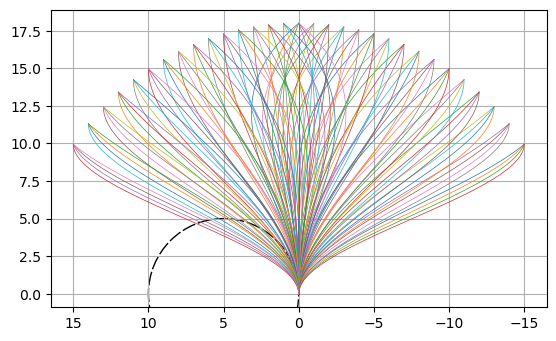

In [4]:
plt.figure()

Y = lambda x, param: param[0]*x**3 + param[1]*x**2
H = lambda x, param: param[0]*3*x**2 + param[1]*2*x
K = lambda x, param: param[0]*6*x + param[1]*2

'''
| X^3   X^2 | | a | = | Y |
| 3X^2  2X  | | b |   | Heading |
'''
getParam = lambda Xe, Ye, He : np.linalg.inv(np.array([[Xe**3, Xe**2],[3*Xe**2, 2*Xe]])) @ np.array([Ye, He])

cnt = 0
hMax = 0
score = 100 # init
R = 5
for (i,j) in zip(goal["X"], goal["Y"]):
    for k in goal["Heading"]:
        if np.sign(j) * np.sign(k) == -1:
            cnt+=1
            continue
        param  = getParam(i,j,k)
        x = np.linspace(0, i, 100)
        h = H(i, param)

        flg =  True
        h =  np.rad2deg(np.arctan2(j - Y(x[-2], param), i - x[-2]))
        if abs(h - np.rad2deg(H(i, param))) > 25:
            if (hMax < h): hMax = h
            flg = False

        if np.all(np.abs(K(x, param)) < 1000000000) and flg:
            plt.plot(Y(x, param), x, linewidth=0.5)
            score = min(score, is90TurnDepictScore(Y(x,param),x, R=R))
        else:
            cnt+=1

print(f"{R}R Score is {score:.3f}")
print(f"OK: {len(goal['X']) * len(goal['Heading']) -cnt}, Out: {cnt}")
print(f"Max Heading: {hMax:.2f} deg")
# plt.xlim(0,R)
# plt.ylim(0,R)
plt.grid()
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().add_patch(patches.Circle((R,0), radius=R, fill=False, linestyle=(5, (10, 2))))
plt.show()

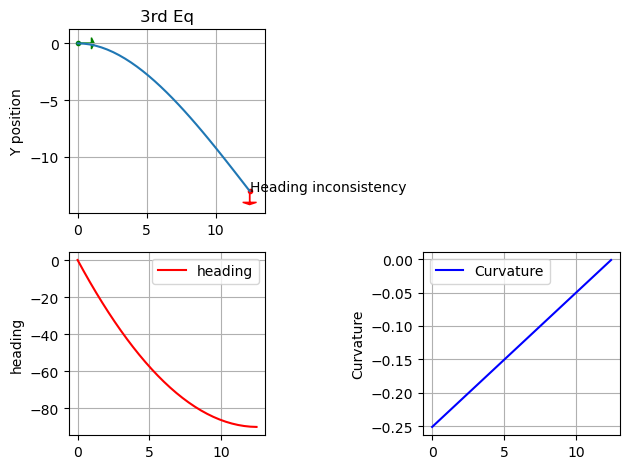

In [5]:
Sample = goal["X"][2],goal["Y"][2],goal["Heading"][0]

x = np.linspace(0, Sample[0], 30)
param  = getParam(Sample[0],Sample[1],Sample[2])

plt.subplot(2, 2, 1)
plt.title("3rd Eq")
plt.plot(0, 0, 'go', label='Start Point', markersize=3)
plt.plot(Sample[0], Sample[1], 'ro', label='End Point', markersize=3)
y = Y(x, param)
plt.grid(True)
plt.ylabel('Y position')

# 방향 벡터 표시
arrow_length = 1.0
# 시작점 방향
heading = H(0, param)
plt.arrow(0, 0, 
         arrow_length*np.cos(heading),
         arrow_length*np.sin(heading),
          head_width=1, head_length=0.2, fc='g', ec='g')

#종료점 방향
plt.arrow(Sample[0], Sample[1],
         arrow_length*np.cos(Sample[2]),
         arrow_length*np.sin(Sample[2]),
         head_width=1, head_length=0.2, fc='r', ec='r')

plt.text(Sample[0], Sample[1], "Heading inconsistency ")
plt.plot(x, y)


# 헤딩 프로파일
plt.subplot(2, 2, 3)
heading = H(x, param)*180/np.pi
plt.plot(x, heading, 'r-', label='heading')
plt.grid(True)
plt.ylabel('heading')
plt.legend()

# 곡률 프로파일
plt.subplot(2, 2, 4)
k = K(x, param)
plt.plot(x, k, 'b-', label='Curvature')
plt.grid(True)
plt.ylabel('Curvature')
plt.legend()

plt.tight_layout()
plt.show()


### 2. Parametric 3차식을 이용한 경로 생성 방식
- 장점: 보다 자유로운 경로에 대한 표현이 가능함 (헤딩각 등)
- 단점: 초기 곡률이 매우 큰값으로 표현되어 Feasible한 주행 경로로 보기 어려우며, Feasible한 경로를 얻기 위한 Factor 튜닝이 까다로운 편

5R Score is 2.724
OK: 5, Out: 274


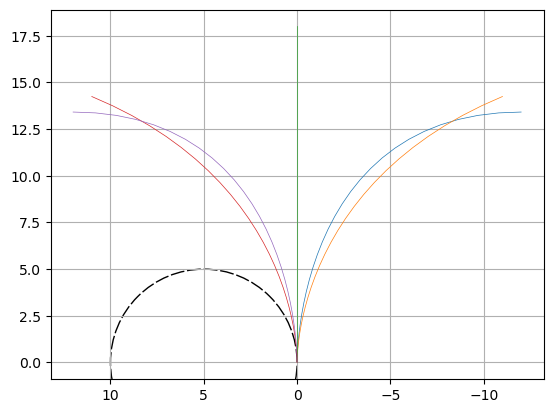

In [6]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt

plt.figure()

def get_position(t, param):
    px = param[0]*t**3 + param[1]*t**2 + param[2]*t
    py = param[3]*t**3 + param[4]*t**2 + param[5]*t
    return px, py

# 속도 벡터 계산
def get_velocity(t, param):
    vx = 3*param[0]*t**2 + 2*param[1]*t + param[2]
    vy = 3*param[3]*t**2 + 2*param[4]*t + param[5]
    return vx, vy

# 가속도 벡터 계산
def get_acceleration(t, param):
    ax = 6*param[0]*t + 2*param[1]
    ay = 6*param[3]*t + 2*param[4]
    return ax, ay

def calculate_curvature(t, param):
    """곡률 계산 함수
    Args:
        t: 시간 파라미터
        param: 경로 계수
    Returns:
        curvature: 곡률 값
    """
    # 1차 미분
    dx, dy = get_velocity(t, param)
    # 2차 미분
    ddx, ddy = get_acceleration(t, param)
    
    # 곡률 계산: κ = |x'y'' - y'x''| / (x'^2 + y'^2)^(3/2)
    numerator = dx*ddy - dy*ddx
    denominator = (dx**2 + dy**2)**(3/2)
    
    # 0으로 나누기 방지
    mask = denominator > 1e-5
    curvature = np.ones_like(t)
    curvature[mask] = numerator[mask] / denominator[mask]
    
    return curvature

def getParametricCoeff(Xe, Ye, He):

    pathLength = np.sqrt(Xe**2 + Ye**2)
    init_vx = Xe / pathLength * 1        # 1 is factor
    init_vy = Ye / pathLength * 0        # 0 is factor
    end_vx = pathLength * np.cos(He) * 2 # 2 is factor
    end_vy = pathLength * np.sin(He) * 2 # 2 is factor

    # 계수
        # X = a3 t^3 + a2 t^2 + a1 t
        # Y = b3 t^3 + b2 t^2 + b1 t
    A = np.array([
        [1, 1, 1, 0, 0, 0],           # x(1) = Xe
        [0, 0, 0, 1, 1, 1],           # y(1) = Ye
        [3, 2, 1, 0, 0, 0],           # x'(1) = end_vx
        [0, 0, 0, 3, 2, 1],           # y'(1) = end_vy
        [0, 0, 1, 0, 0, 0],           # x'(0) = init_vx
        [0, 0, 0, 0, 0, 1],           # y'(0) = init_vy
    ], dtype=float)

    B = np.array([Xe, Ye, end_vx, end_vy, init_vx, init_vy])
    coefficients = solve(A, B)
        
    return coefficients

score = 100 # init
t = np.linspace(0,1,30)
cnt =0
for (i, j) in zip(goal["X"], goal["Y"]):
    for k in goal["Heading"]:
        if np.sign(j) * np.sign(k)==-1:
            cnt+=1
            continue

        try:
            param = getParametricCoeff(i,j,k)
            pos = get_position(t, param)
            curv = calculate_curvature(t, param)
            
            if np.all(np.abs(curv) < 1):
                plt.plot(pos[1], pos[0], linewidth=0.5)
                score = min(score, is90TurnDepictScore(pos[1], pos[0], R=R))
            else:
                cnt+=1
        except Exception as e:
            cnt+=1
            print(e)

plt.grid()
# plt.xlim(0,R)
# plt.ylim(0,R)
print(f"{R}R Score is {score:.3f}")
print(f"OK: {len(goal['X']) * len(goal['Heading']) -cnt}, Out: {cnt}")
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().add_patch(patches.Circle((R,0), radius=R, fill=False, linestyle=(5, (10, 2))))
plt.show()

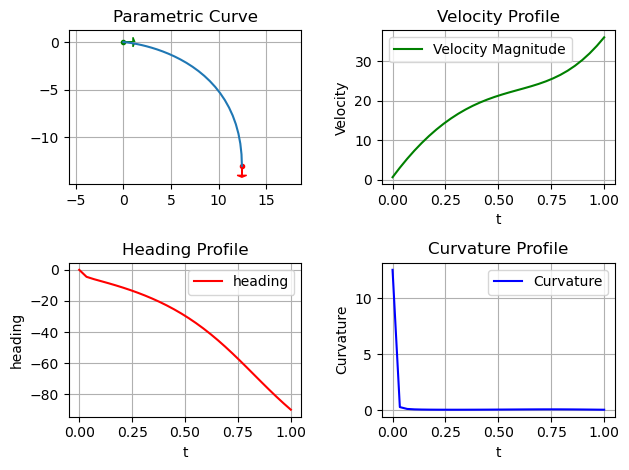

X = -24.21 t^3 + 35.97 t^2 + 0.69 t
Y = -10.00 t^3 + -3.00 t^2 + 0.00 t


In [7]:
# check the sample
plt.figure()
Sample = goal["X"][2],goal["Y"][2],goal["Heading"][0]
param = getParametricCoeff(Sample[0], Sample[1], Sample[2])

plt.subplot(2, 2, 1)
plt.plot(0, 0, 'go', label='Start Point', markersize=3)
plt.plot(Sample[0], Sample[1], 'ro', label='End Point', markersize=3)
px, py = get_position(t, param)
plt.plot(px, py)

# 방향 벡터 표시
arrow_length = 1.0
# 시작점 방향
vx0, vy0= get_velocity(0, param)
magnitude0 = np.sqrt(vx0**2 + vy0**2)
plt.arrow(0, 0, 
         arrow_length*vx0/magnitude0, 
         arrow_length*vy0/magnitude0,
          head_width=1, head_length=0.2, fc='g', ec='g')

#종료점 방향
plt.arrow(Sample[0], Sample[1],
         arrow_length*np.cos(Sample[2]),
         arrow_length*np.sin(Sample[2]),
         head_width=1, head_length=0.2, fc='r', ec='r')

plt.grid(True)
plt.axis('equal')
plt.title('Parametric Curve')

# 속도 프로파일
plt.subplot(2, 2, 2)
vx, vy = get_velocity(t, param)
v_magnitude = np.sqrt(vx**2 + vy**2)
plt.plot(t, v_magnitude, 'g-', label='Velocity Magnitude')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Velocity')
plt.title('Velocity Profile')
plt.legend()

# 헤딩 프로파일
plt.subplot(2, 2, 3)
heading = np.arctan2(vy, vx)*180/np.pi
plt.plot(t, heading, 'r-', label='heading')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('heading')
plt.title('Heading Profile')
plt.legend()

# 곡률 프로파일
plt.subplot(2, 2, 4)
ax, ay = get_acceleration(t, param)
curvature = np.abs(vx*ay - vy*ax) / (vx**2 + vy**2)**(3/2)
plt.plot(t, curvature, 'b-', label='Curvature')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Curvature')
plt.title('Curvature Profile')
plt.legend()

plt.tight_layout()
plt.show()

# X = a3 t^3 + a2 t^2 + a1 t
# Y = b3 t^3 + b2 t^2 + b1 t
print(f"X = {param[0]:.2f} t^3 + {param[1]:.2f} t^2 + {param[2]:.2f} t")
print(f"Y = {param[3]:.2f} t^3 + {param[4]:.2f} t^2 + {param[5]:.2f} t")


### 3. 에리미트 스플라인을 이용한 경로 생성 방식
- 장점: 자유로운 경로에 대한 표현이 가능함, 파라메트릭 방식보다 부드러운 곡선임
- 단점: 초기 곡률이 크게 발생할 수 있어, 경로 생성 factor 튜닝이 필요하나, 직관적인 편

5R Score is 0.816
OK: 157, Out: 122


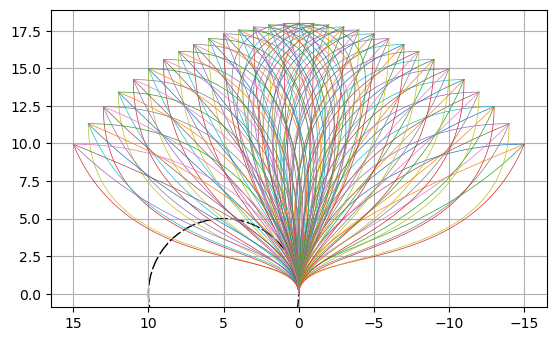

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 에르미트 스플라인 함수 정의
def hermite_spline(P0, P1, m0, m1, t):
    h0 = 2*t**3 - 3*t**2 + 1
    h1 = -2*t**3 + 3*t**2
    h2 = t**3 - 2*t**2 + t
    h3 = t**3 - t**2

    return h0 * P0 + h1 * P1 + h2 * m0 + h3 * m1

def hermite_spline_with_coefficients(P0, P1, m0, m1):
    """
    에르미트 스플라인의 계수들을 반환하는 함수
    Returns:
    a, b, c, d: 3차 다항식의 계수들 P(t) = at³ + bt² + ct
    """
    a = 2*P0 - 2*P1 + m0 + m1
    b = -3*P0 + 3*P1 - 2*m0 - m1
    c = m0
    
    param = [a[0], b[0], c[0], a[1], b[1], c[1]]

    return param


# t 값 생성 (0에서 1까지)
t = np.linspace(0, 1, 100)
StartFactor = 10
EndFactor = 30

plt.figure()
cnt = 0
score = 100 # init

for (i,j) in zip(goal["X"],goal["Y"]):
    for k in goal["Heading"]:
        if np.sign(j) * np.sign(k)==-1:
            cnt+=1
            continue
            
        P0 = np.array([0, 0])
        P1 = np.array([i, j])
        m0 = np.array([1, 0]) * StartFactor
        m1 = np.array([np.cos(k), np.sin(k)]) * EndFactor

        # 에르미트 스플라인 계산
        param = hermite_spline_with_coefficients(P0, P1, m0, m1)
        spline_points = np.array([hermite_spline(P0, P1, m0, m1, tt) for tt in t])

        curv = calculate_curvature(t, param)
        if np.all(np.abs(curv) < 1):
            plt.plot(spline_points[:, 1], spline_points[:, 0],linewidth=0.5)
            score = min(score, is90TurnDepictScore(spline_points[:,1], spline_points[:,0], R=R))

        else:
            cnt+=1

# plt.xlim(0,R)
# plt.ylim(0,R)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
print(f"{R}R Score is {score:.3f}")
print(f"OK: {len(goal['X']) * len(goal['Heading']) -cnt}, Out: {cnt}")
plt.gca().add_patch(patches.Circle((R,0), radius=R, fill=False, linestyle=(5, (10, 2))))
plt.show()


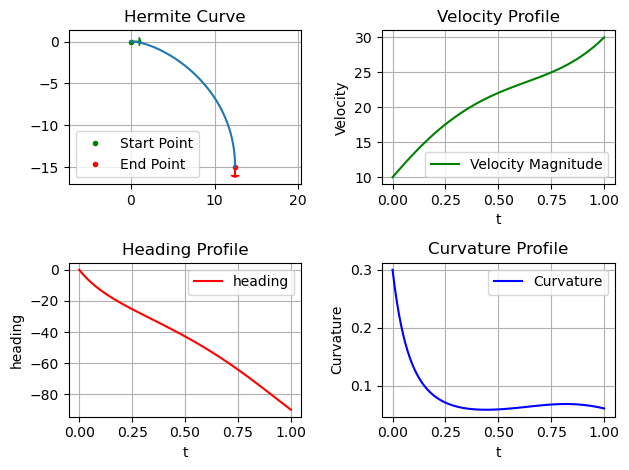

X = -14.90 t^3 + 17.35 t^2 + 10.00 t
Y = 0.00 t^3 + -15.00 t^2 + 0.00 t


In [9]:
# check the sample
plt.figure()
Sample = goal["X"][2],goal["Y"][0],goal["Heading"][0]

P0 = np.array([0, 0])
P1 = np.array([Sample[0], Sample[1]])
m0 = np.array([1, 0]) * StartFactor
m1 = np.array([np.cos(Sample[2]), np.sin(Sample[2])]) * EndFactor

param = hermite_spline_with_coefficients(P0, P1, m0, m1)

plt.subplot(2, 2, 1)
plt.plot(0, 0, 'go', label='Start Point', markersize=3)
plt.plot(Sample[0], Sample[1], 'ro', label='End Point', markersize=3)
px, py = get_position(t, param)
plt.plot(px, py)

# 방향 벡터 표시
arrow_length = 1.0
# 시작점 방향
vx0, vy0= get_velocity(0, param)
magnitude0 = np.sqrt(vx0**2 + vy0**2)
plt.arrow(0, 0, 
         arrow_length*vx0/magnitude0, 
         arrow_length*vy0/magnitude0,
          head_width=1, head_length=0.2, fc='g', ec='g')

#종료점 방향
plt.arrow(Sample[0], Sample[1],
         arrow_length*np.cos(Sample[2]),
         arrow_length*np.sin(Sample[2]),
         head_width=1, head_length=0.2, fc='r', ec='r')

plt.grid(True)
plt.axis('equal')
plt.legend()
plt.title('Hermite Curve')

# 속도 프로파일
plt.subplot(2, 2, 2)
vx, vy = get_velocity(t, param)
v_magnitude = np.sqrt(vx**2 + vy**2)
plt.plot(t, v_magnitude, 'g-', label='Velocity Magnitude')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Velocity')
plt.title('Velocity Profile')
plt.legend()

# 헤딩 프로파일
plt.subplot(2, 2, 3)
heading = np.arctan2(vy, vx)*180/np.pi
plt.plot(t, heading, 'r-', label='heading')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('heading')
plt.title('Heading Profile')
plt.legend()

# 곡률 프로파일
plt.subplot(2, 2, 4)
ax, ay = get_acceleration(t, param)
curvature = np.abs(vx*ay - vy*ax) / (vx**2 + vy**2)**(3/2)
plt.plot(t, curvature, 'b-', label='Curvature')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Curvature')
plt.title('Curvature Profile')
plt.legend()

plt.tight_layout()
plt.show()

# X = a3 t^3 + a2 t^2 + a1 t
# Y = b3 t^3 + b2 t^2 + b1 t
print(f"X = {param[0]:.2f} t^3 + {param[1]:.2f} t^2 + {param[2]:.2f} t")
print(f"Y = {param[3]:.2f} t^3 + {param[4]:.2f} t^2 + {param[5]:.2f} t")


In [10]:
from scipy.integrate import cumtrapz
import scipy.interpolate as spi

def calculate_arc_length(t, dx_dt, dy_dt):
    """
    매개변수 t에서의 호의 길이 계산
    """
    speed_param = np.sqrt(dx_dt**2 + dy_dt**2)
    arc_length = cumtrapz(speed_param, t, initial=0)
    return arc_length

def find_t_from_distance(distance, t_array, arc_length_array):
    """
    주어진 거리에 해당하는 매개변수 t 값을 찾음
    """
    interp_func = spi.interp1d(arc_length_array, t_array, bounds_error=False, fill_value="extrapolate")

    return interp_func(distance)

def calculate_trajectory(param, velocity, acceleration, duration=3.0, dt=0.1):
    """
    호의 길이를 기반으로 차량 궤적 계산
    """

    a3, a2, a1 = param[0], param[1], param[2]
    b3, b2, b1 = param[3], param[4], param[5]

    t_param = np.linspace(0, 1, 1000)
    
    # 위치와 도함수 계산
    x_spline = a3 * t_param**3 + a2 * t_param**2 + a1 * t_param
    y_spline = b3 * t_param**3 + b2 * t_param**2 + b1 * t_param
    
    dx_dt = 3 * a3 * t_param**2 + 2 * a2 * t_param + a1
    dy_dt = 3 * b3 * t_param**2 + 2 * b2 * t_param + b1
    
    # 호의 길이 계산
    arc_length = calculate_arc_length(t_param, dx_dt, dy_dt)
    total_length = arc_length[-1]
    
    # 시간 배열 생성
    time = np.arange(0, duration + dt, dt)
    
    # 각 시간에서의 이동 거리 계산
    distances = velocity * time + 0.5 * acceleration * time**2
    distances = np.maximum.accumulate(distances)
    
    # 각 거리에서의 매개변수 t 계산
    wrapped_distances =  distances
    t_values = find_t_from_distance(wrapped_distances, t_param, arc_length)
    
    # 최종 위치 계산
    x_traj = a3 * t_values**3 + a2 * t_values**2 + a1 * t_values
    y_traj = b3 * t_values**3 + b2 * t_values**2 + b1 * t_values
    
    # 각 위치에서의 헤딩각 계산
    dx_traj = 3 * a3 * t_values**2 + 2 * a2 * t_values + a1
    dy_traj = 3 * b3 * t_values**2 + 2 * b2 * t_values + b1
    heading = np.arctan2(dy_traj, dx_traj)
    
    return {
        'time': time,
        'x': x_traj,
        'y': y_traj,
        'heading': heading,
        'distance': distances,
        'spline_x': x_spline,
        'spline_y': y_spline,
        'total_length': total_length
    }

def plot_trajectory(trajectory):
    """
    계산된 궤적 시각화
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    # 경로 플롯
    ax1.plot(trajectory['spline_x'], trajectory['spline_y'], 'b--', label='Spline Path', linewidth = 3)
    ax1.plot(trajectory['x'], trajectory['y'], 'r-', label='Vehicle Trajectory')
    ax1.set_title(f"Global Path (Total Length: {trajectory['total_length']:.2f}m)")
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.grid(True)
    ax1.legend()
    ax1.axis('equal')
    
    # 거리-시간 플롯
    ax2.plot(trajectory['time'], trajectory['distance'])
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Distance (m)')
    ax2.grid(True)
    
    # 헤딩각-시간 플롯
    ax3.plot(trajectory['time'], np.degrees(trajectory['heading']))
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Heading (degrees)')
    ax3.grid(True)
    
    plt.tight_layout()
    return fig


    

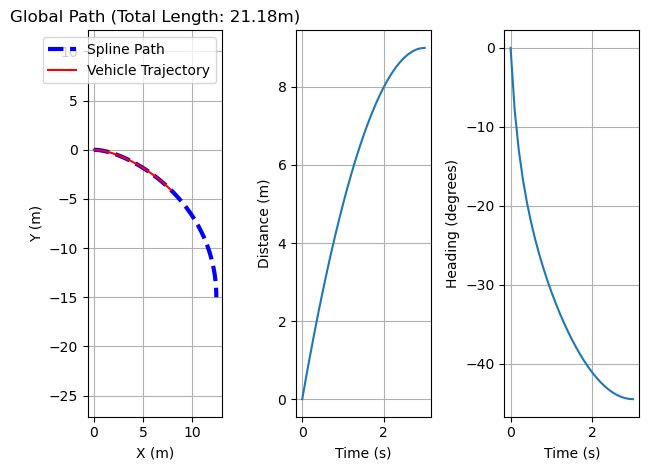

In [11]:
# 경로 생성 예시

velocity = 6.0  # m/s
acceleration = -2 # m/s2

# 궤적 계산
traj = calculate_trajectory(param, velocity, acceleration)

# 결과 시각화
plot_trajectory(traj)
plt.show()

### to-do

1. 지도 유관 주행 경로 (450개 샘플 생성)

    1) 에르미트 스플라인 통한 전역 경로 생성 (150여개)
    2) 차량 속도 { [5m/s 등속], [5m/s, -2m/s2 등감속], [2m/s, 1m/s2 등가속]}: 3개

2. 키네마틱스 주행 경로 (56개)
    1) Turn 반경(좌, 우 1m, 2m, 4m, 6m): 8개
    2) 차량 속도 { [2m/s 등속], [3m/s 등속], [4m/s 등속], [5m/s 등속], [6m/s 등속], [5m/s, -2.5m/s2 등감속], [2m/s, 1m/s2 등가속]}: 7개 

3. 완전 정지 (1개)

- 총 507개 경로의 vocab